# EXPLORE Data Science Academy Classification Hackathon
## Overview
South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.
From South African Government



In [1]:
#import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [2]:
#Import Datasets
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

In [3]:
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [5]:
#Check for blank rows
print('train data has', train.isnull().sum()[1], 'blank rows')
print('test data has', test.isnull().sum()[1], 'blank rows')

train data has 0 blank rows
test data has 0 blank rows


The data has no blank rows.

Next, we take a look at the distribution of the target `lang_id` variable

In [6]:
#map lang id with language name
lang_map = {
'afr' : 'Afrikaans',
'eng' : 'English',
'nbl' : 'isiNdebele',
'nso' : 'Sepedi',
'sot' : 'Sesotho',
'ssw' : 'siSwati',
'tsn' : 'Setswana',
'tso' : 'Xitsonga',
'ven' : 'Tshivenda',
'xho' : 'isiXhosa',
'zul' : 'isiZulu' 
}

lang = train['lang_id'].map(lang_map).value_counts()

<AxesSubplot:>

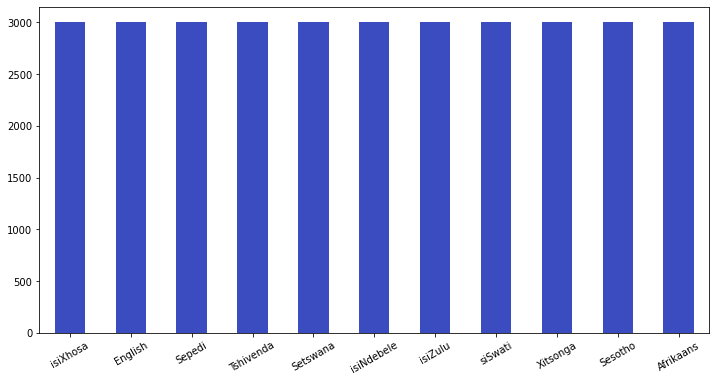

In [7]:
#wisualize the distribution
plt.figure(figsize=(12,6))
lang.plot(kind='bar', figsize=(12,6), rot=30, colormap='coolwarm')

We can observe that the data is balanced i.e. each of the labels are equal in number. This is essential for our algirithm.

Next, we would separate the features from the target variable. We would also encode the target variable for easy training.

In [8]:
#define feature and target variable
X = train['text']
y = train['lang_id']

#Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)

For the modelling section, we would be trying a few algorithms that are suitable for NLP classification tasks. But first, we would be creating a pipeline that contains a vectorizer to train our model.

The models we would train are:
* Linear SVC
* Multinomial Naive Bayes
* Complement Naive Bayes

The models would be evaluated using `cross_val_score`

In [9]:
#Linear SVC
from sklearn.calibration import CalibratedClassifierCV
ls = CalibratedClassifierCV(LinearSVC(C=10))
pipe2 = Pipeline([('vect', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),('model', ls)])
pipe2.fit(X, y)
scores = cross_val_score(pipe2, X, y, scoring='f1_weighted', cv=2)
print(scores)
print(scores.mean())

[0.99605649 0.99636311]
0.996209801853605


In [10]:
#Multinomial Naive Bayes
nb = MultinomialNB()
pipe1 = Pipeline([('vect', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),('model', nb)])
pipe1.fit(X, y)
scores = cross_val_score(pipe1, X, y, scoring='f1_weighted', cv=2)
print(scores)
print(scores.mean())

[0.99842284 0.9982418 ]
0.9983323191540634


In [11]:
#Complement Naive Bayes
cnb = ComplementNB()
pipe3 = Pipeline([('vect', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),('model', cnb)])
pipe3.fit(X, y)
scores = cross_val_score(pipe3, X, y, scoring='f1_weighted', cv=2)
print(scores)
print(scores.mean())

[0.99757165 0.99787825]
0.9977249503002095


Our models performed relatively well. To improve it however, we would employ the following algorithms:
* Bagging 
* Stacking
* Soft Voting
* Hard Voting



In [12]:
#Bagging classifier
clf = BaggingClassifier(base_estimator=LinearSVC(),
                       n_estimators=10, random_state=0)
pipe_clf = Pipeline([('vect', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),('model', clf)])
pipe_clf.fit(X, y)
scores = cross_val_score(pipe_clf, X, y, scoring='f1_weighted', cv=2)
print(scores)
print(scores.mean())

[0.99551184 0.99533363]
0.9954227328564211


In [13]:
#Stacking
models = [("ET", pipe1),("XGB", pipe3), ('ls', pipe2)]
meta_learner_reg = LogisticRegression()

s_clf = StackingClassifier(estimators=models, final_estimator=meta_learner_reg)
s_clf.fit(X, y)


StackingClassifier(estimators=[('ET',
                                Pipeline(steps=[('vect',
                                                 TfidfVectorizer(max_df=0.9,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 stop_words='english')),
                                                ('model', MultinomialNB())])),
                               ('XGB',
                                Pipeline(steps=[('vect',
                                                 TfidfVectorizer(max_df=0.9,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 stop_words='english')),
                                                ('model', ComplementNB())])),
                               ('ls',
                                Pipeline(steps=[('vect',
                                                 TfidfVectorizer(max_df=0.9,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 stop_words='english')),
                                                ('model',
                                                 CalibratedClassifierCV(base_estimator=LinearSVC(C=10)))]))],
                   final_estimator=LogisticRegression())

In [14]:
# Soft Voting
models = [("ET", pipe1),("XGB", pipe3), ('ls', pipe2)]
v_clf = VotingClassifier(estimators=models, voting='soft', weights=[2,2,1])
v_clf.fit(X, y)

VotingClassifier(estimators=[('ET',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.9,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english')),
                                              ('model', MultinomialNB())])),
                             ('XGB',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.9,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english')),
                                              ('model', ComplementNB())])),
                             ('ls',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.9,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english')),
                                              ('model',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(C=10)))]))],
                 voting='soft', weights=[2, 2, 1])

In [15]:
#Hard Voting
models = [("ET", pipe1),("XGB", pipe3), ('ls', pipe2)]
v_clf3 = VotingClassifier(estimators=models, voting='hard', weights=[2,2,1])
v_clf3.fit(X, y)

VotingClassifier(estimators=[('ET',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.9,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english')),
                                              ('model', MultinomialNB())])),
                             ('XGB',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.9,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english')),
                                              ('model', ComplementNB())])),
                             ('ls',
                              Pipeline(steps=[('vect',
                                               TfidfVectorizer(max_df=0.9,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english')),
                                              ('model',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(C=10)))]))],
                 weights=[2, 2, 1])

In [16]:
#Make Kaggle Submission
y_pred = s_clf.predict(test['text'])
y_pred = le.inverse_transform(y_pred)
Final_Table = {'index': test.index +1, 'lang_id': y_pred}
submission = pd.DataFrame(data=Final_Table)
submission.to_csv('stack5.csv', index=False)
submission

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot
